We are developing a robust machine learning model that is capable
of classifying malware samples into their respective families based on binary content and assembly analysis

1- We start by importing all the needed libraries

In [1]:
# import warnings
# warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
# matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from nltk.util import ngrams
from sklearn.feature_selection import SelectKBest, chi2, f_regression

import scipy.sparse
import gc
import pickle as pkl
from datetime import datetime as dt
import dask.dataframe as dd

2- we check if the data is seperated into byes and assembly , and as we know it is not we will be seperating it by code instead of doing it manually

In [2]:
#separating byte files and asm files
# %matplotlib inline

# source = 'sample'
# destination_1 = 'train_Bytes'
# destination_2 = 'trainAsm'


# if not os.path.isdir(destination_1):
#     os.makedirs(destination_1)
# if not os.path.isdir(destination_2):
#     os.makedirs(destination_2)


# if os.path.isdir(source):
#     data_files = os.listdir(source)
#     for file in data_files:
#         print(file)
#         if (file.endswith("bytes")):
#             shutil.move(source+'\\'+file,destination_1)
#         if (file.endswith("asm")):
#             shutil.move(source+'\\'+file,destination_2)

02IOCvYEy8mjiuAQHax3.asm
02IOCvYEy8mjiuAQHax3.bytes
02JqQ7H3yEoD8viYWlmS.asm
02JqQ7H3yEoD8viYWlmS.bytes
02K5GMYITj7bBoAisEmD.asm
02K5GMYITj7bBoAisEmD.bytes
02mlBLHZTDFXGa7Nt6cr.asm
02mlBLHZTDFXGa7Nt6cr.bytes
02MRILoE6rNhmt7FUi45.bytes
02zcUmKV16Lya5xqnPGB.asm
02zcUmKV16Lya5xqnPGB.bytes
03nJaQV6K2ObICUmyWoR.bytes
04BfoQRA6XEshiNuI7pF.bytes
04cvLCVPqBMs6yn5xGlE.bytes
04EjIdbPV5e1XroFOpiN.bytes
04hSzLv5s2TDYPlcgpHB.bytes
04mcPSei852tgIKUwTJr.bytes
04QzZ3DVdPsEp9elLR65.bytes
04sJnMaORYc1SV5pKjrP.bytes
0A32eTdBKayjCWhZqDOQ.bytes
0ACDbR5M3ZhBJajygTuf.asm
0ACDbR5M3ZhBJajygTuf.bytes
0AguvpOCcaf2myVDYFGb.asm
0AguvpOCcaf2myVDYFGb.bytes
0akIgwhWHYm1dzsNqBFx.asm
0akIgwhWHYm1dzsNqBFx.bytes
0aKlH1MRxLmv34QGhEJP.asm
0aKlH1MRxLmv34QGhEJP.bytes
0AnoOZDNbPXIr2MRBSCJ.asm
0AnoOZDNbPXIr2MRBSCJ.bytes
0ASH2csN7k8jZyoRaqtn.bytes
0aSTGBVRXeJhx5OcpsgC.asm
0aSTGBVRXeJhx5OcpsgC.bytes
0aU7XWsr8RtN94jvo3lG.asm
0aU7XWsr8RtN94jvo3lG.bytes
0AV6MPlrTWG4fYI7NBtQ.asm
0AV6MPlrTWG4fYI7NBtQ.bytes
0aVNj3qFgEZI6Akf4Kuv.asm
0a

4-We try to distribute malware classes in whole data set

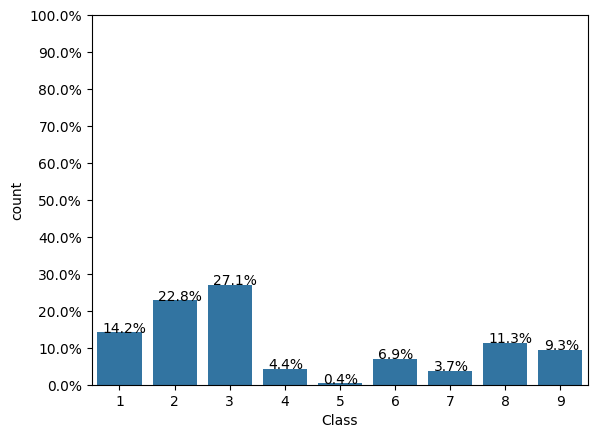

In [2]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

5- Trying to classify File size of byte files as a feature

In [5]:
#file sizes of byte files

files=os.listdir('trainBytes')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('train_Bytes/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('trainBytes/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  5.012695      9
1  01IsoiSMh5gxyDYTl4CB  6.556152      2
2  01jsnpXSAlgw6aPeDxrU  4.602051      9
3  01kcPWA9K2BOxQeS5Rju  0.679688      1
4  01SuzwMJEIXsK7A8dQbl  0.438965      8


6- box plots of file size (.byte files) feature

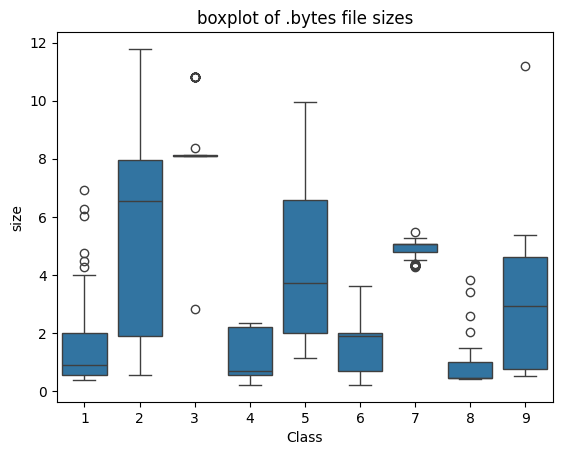

In [6]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

7- Uni-Gram Byte Feature extraction from byte files

In [8]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000

files = os.listdir('trainBytes')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('trainBytes/'+file+".txt", 'w+')
        with open('trainBytes/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('trainBytes/'+file+".bytes")
        text_file.close()

files = os.listdir('trainBytes')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0



# program to convert into bag of words of trainBytes
# this is custom-built bag of words this is unigram bag of words
# This is a Custom Implementation of CountVectorizer as CountVectorizer will NOT suport working on such huge file system of 50GB
# For this Uni-Gram feature creating and writing to a file named 'result.csv'

byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")

byte_feature_file.write("\n")

for file in files:
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('trainBytes/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i, row in enumerate(feature_matrix[k]):
        if i!=len(feature_matrix[k])-1:
            byte_feature_file.write(str(row)+",")
        else:
            byte_feature_file.write(str(row))
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

In [9]:
byte_features=pd.read_csv("result.csv")
byte_features['ID']  = byte_features['ID'].str.split('.').str[0]
byte_features.head(2)

,ID,0,1,2,3,4,5,6,7,8,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,??
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,2804,3687,3101,3211,3097,2758,3099,2759,5753,1824
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,451,6536,439,281,302,7639,518,17001,54902,8588


In [10]:
data_size_byte.head(2)

,ID,size,Class
0,01azqd4InC7m9JpocGv5,5.012695,9
1,01IsoiSMh5gxyDYTl4CB,6.556152,2


In [11]:
byte_features_with_size = byte_features.merge(data_size_byte, on='ID')
byte_features_with_size.to_csv("result_with_size.csv")
byte_features_with_size.head(2)

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,3101,3211,3097,2758,3099,2759,5753,1824,5.012695,9
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,439,281,302,7639,518,17001,54902,8588,6.556152,2


In [12]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

result = normalize(byte_features_with_size)

In [13]:
result.head(2)

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,0.727185,0.030960,0.005985,0.011400,0.003060,0.033033,0.003833,0.007593,0.010080,...,0.027761,0.025255,0.032275,0.114648,0.044161,0.014302,0.028765,0.000707,0.414933,9
1,01IsoiSMh5gxyDYTl4CB,0.047624,0.066591,0.015466,0.021436,0.007951,0.069893,0.008843,0.018005,0.031658,...,0.003930,0.002203,0.003138,0.317769,0.007346,0.088372,0.278989,0.003331,0.548348,2


In [14]:
data_y = result['Class']
result.head()

,ID,0,1,2,3,4,5,6,7,8,...,f9,fa,fb,fc,fd,fe,ff,??,size,Class
0,01azqd4InC7m9JpocGv5,0.727185,0.030960,0.005985,0.011400,0.003060,0.033033,0.003833,0.007593,0.010080,...,0.027761,0.025255,0.032275,0.114648,0.044161,0.014302,0.028765,0.000707,0.414933,9
1,01IsoiSMh5gxyDYTl4CB,0.047624,0.066591,0.015466,0.021436,0.007951,0.069893,0.008843,0.018005,0.031658,...,0.003930,0.002203,0.003138,0.317769,0.007346,0.088372,0.278989,0.003331,0.548348,2
2,01jsnpXSAlgw6aPeDxrU,0.112602,0.076279,0.005454,0.007229,0.008192,0.095333,0.009460,0.005555,0.031031,...,0.020071,0.022690,0.029835,0.102705,0.039696,0.013891,0.249674,0.000182,0.379437,9
3,01kcPWA9K2BOxQeS5Rju,0.025062,0.009318,0.001514,0.002379,0.001139,0.006252,0.000577,0.001239,0.003643,...,0.004342,0.003627,0.005369,0.047025,0.006676,0.003911,0.040194,0.005407,0.040392,1
4,01SuzwMJEIXsK7A8dQbl,0.023458,0.005274,0.000607,0.001230,0.000497,0.004052,0.000274,0.000588,0.001405,...,0.003133,0.001636,0.002481,0.027050,0.003110,0.001212,0.010671,0.003494,0.019584,8


8- Multivariate Analysis on byte files

C:\Users\youse\AppData\Local\Temp\ipykernel_3024\112834616.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))


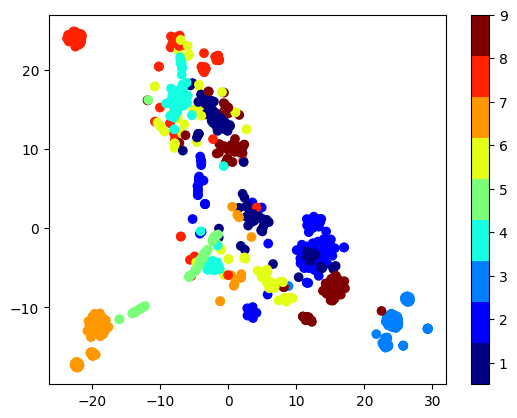

In [15]:
# modified_data = result.drop(['ID', 'Class'], axis=1)
# print(modified_data.shape)
# print(result.columns)  # This will show you all column names in the DataFrame.

#multivariate analysis on byte files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

C:\Users\youse\AppData\Local\Temp\ipykernel_3024\1695613525.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))


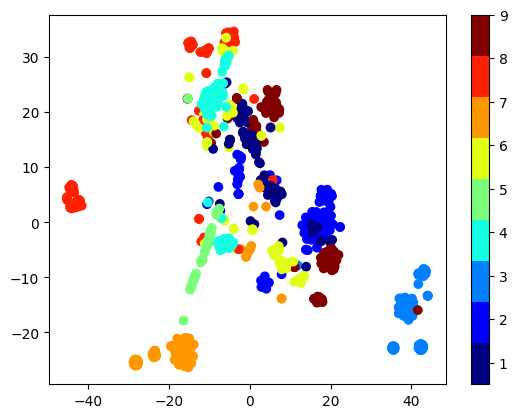

In [16]:
#multivariate analysis on byte files
#this is with perplexity 50

# modified_data = result.drop(['ID', 'Class'], axis=1)
# print(modified_data.shape)

# xtsne=TSNE(perplexity=50)
# results=xtsne.fit_transform(result.drop(['ID'], axis=1))
# vis_x = results[:, 0]
# vis_y = results[:, 1]
# plt.scatter(vis_x, vis_y, c = data_y, cmap=plt.cm.get_cmap("jet", 9))
# plt.colorbar(ticks=range(10))
# plt.clim(0.5, 9)
# plt.show()


#this is with perplexity 30
xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result.drop(['ID','Class'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

9- Train Test split of only Byte Files Features ¶


In [17]:
data_y = result['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [18]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 538
Number of data points in test data: 169
Number of data points in cross validation data: 135


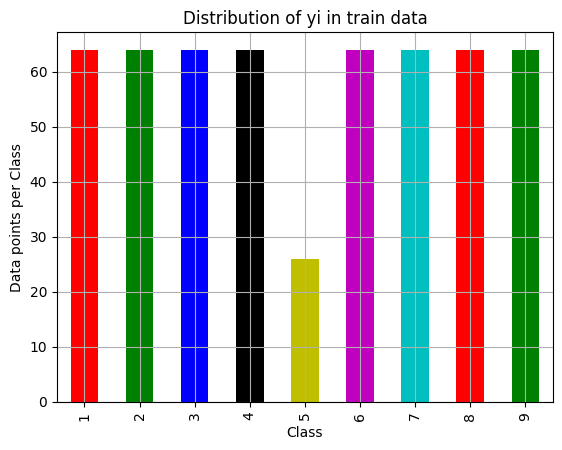

Number of data points in class 1 : 64 ( 11.896 %)
Number of data points in class 2 : 64 ( 11.896 %)
Number of data points in class 3 : 64 ( 11.896 %)
Number of data points in class 4 : 64 ( 11.896 %)
Number of data points in class 6 : 64 ( 11.896 %)
Number of data points in class 7 : 64 ( 11.896 %)
Number of data points in class 8 : 64 ( 11.896 %)
Number of data points in class 9 : 64 ( 11.896 %)
Number of data points in class 5 : 26 ( 4.833 %)
--------------------------------------------------------------------------------


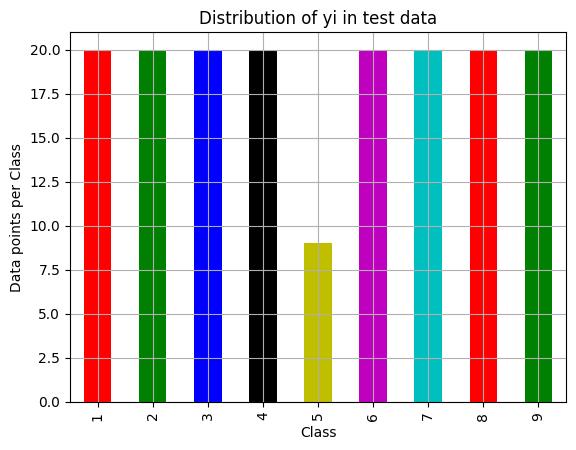

Number of data points in class 1 : 20 ( 11.834 %)
Number of data points in class 2 : 20 ( 11.834 %)
Number of data points in class 3 : 20 ( 11.834 %)
Number of data points in class 4 : 20 ( 11.834 %)
Number of data points in class 6 : 20 ( 11.834 %)
Number of data points in class 7 : 20 ( 11.834 %)
Number of data points in class 8 : 20 ( 11.834 %)
Number of data points in class 9 : 20 ( 11.834 %)
Number of data points in class 5 : 9 ( 5.325 %)
--------------------------------------------------------------------------------


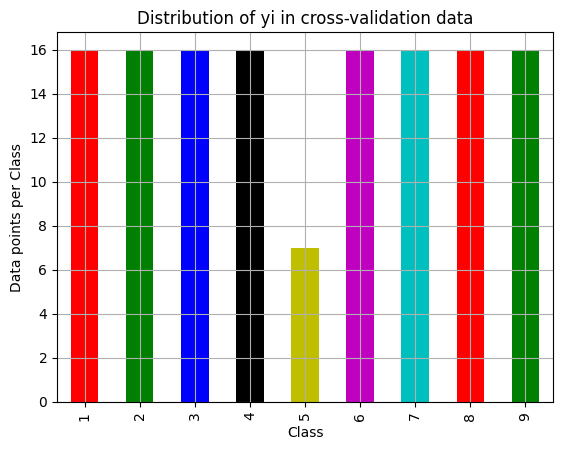

Number of data points in class 1 : 16 ( 11.852 %)
Number of data points in class 2 : 16 ( 11.852 %)
Number of data points in class 3 : 16 ( 11.852 %)
Number of data points in class 4 : 16 ( 11.852 %)
Number of data points in class 6 : 16 ( 11.852 %)
Number of data points in class 7 : 16 ( 11.852 %)
Number of data points in class 8 : 16 ( 11.852 %)
Number of data points in class 9 : 16 ( 11.852 %)
Number of data points in class 5 : 7 ( 5.185 %)


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# It returns a dict, keys as class labels and values as the number of data points in that class
train_class_distribution = y_train.value_counts().sort_index()
test_class_distribution = y_test.value_counts().sort_index()
cv_class_distribution = y_cv.value_counts().sort_index()

# Define a list of colors, repeating as necessary
my_colors = ['r', 'g', 'b', 'k', 'y', 'm', 'c']
train_colors = my_colors[:len(train_class_distribution)]

train_class_distribution.plot(kind='bar', color=train_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in train data')
plt.grid()
plt.show()

# Ref: argsort https://docs.scipy.org/doc/numpy/reference/generated/numpy.argsort.html
# -(train_class_distribution.values): the minus sign will give us in decreasing order
sorted_yi = np.argsort(-train_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i + 1, ':', train_class_distribution.values[i], '(', np.round((train_class_distribution.values[i] / y_train.shape[0] * 100), 3), '%)')

print('-' * 80)
test_colors = my_colors[:len(test_class_distribution)]
test_class_distribution.plot(kind='bar', color=test_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in test data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-test_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i + 1, ':', test_class_distribution.values[i], '(', np.round((test_class_distribution.values[i] / y_test.shape[0] * 100), 3), '%)')

print('-' * 80)
cv_colors = my_colors[:len(cv_class_distribution)]
cv_class_distribution.plot(kind='bar', color=cv_colors)
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of yi in cross-validation data')
plt.grid()
plt.show()

sorted_yi = np.argsort(-cv_class_distribution.values)
for i in sorted_yi:
    print('Number of data points in class', i + 1, ':', cv_class_distribution.values[i], '(', np.round((cv_class_distribution.values[i] / y_cv.shape[0] * 100), 3), '%)')


Now , we compare the the 3 types of data 

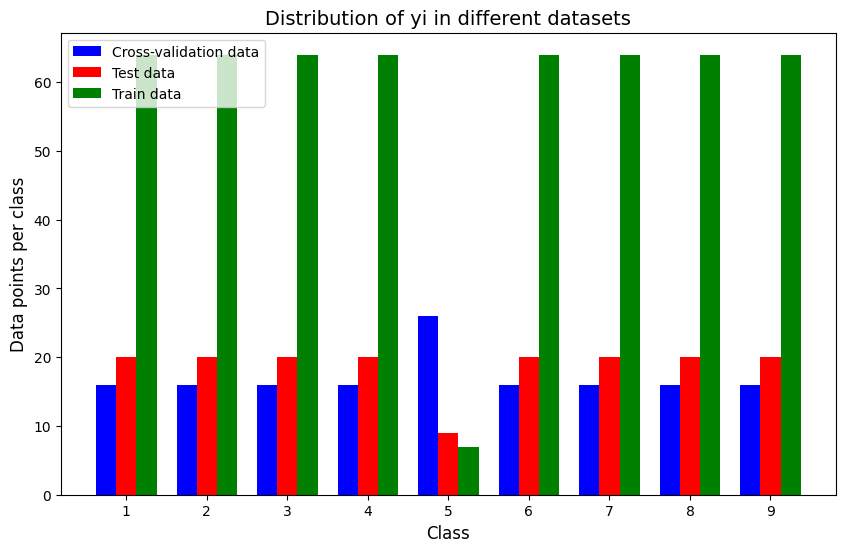

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Data points for cross-validation, test, and training datasets
cross_data = [16,16,16,16,26,16,16,16,16]
test_data  = [20,20,20,20,9,20,20,20,20]
train_data = [64,64,64,64,7,64,64,64,64]

# Class labels
classes = list(range(1, 10))

# Create the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Define the width of the bars and their positions
bar_width = 0.25
r1 = np.arange(len(cross_data))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plot data
ax.bar(r1, cross_data, color='b', width=bar_width, label='Cross-validation data')
ax.bar(r2, test_data, color='r', width=bar_width, label='Test data')
ax.bar(r3, train_data, color='g', width=bar_width, label='Train data')

# Add labels, title and legend
ax.set_xlabel('Class', fontsize=12)
ax.set_ylabel('Data points per class', fontsize=12)
ax.set_title('Distribution of yi in different datasets', fontsize=14)
ax.set_xticks([r + bar_width for r in range(len(cross_data))])
ax.set_xticklabels(classes)
ax.legend()

# Show plot
plt.show()


In [21]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

10- Random Model ONLY on bytes files

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


Log loss on Cross Validation Data using Random Model 2.5944284901833448
Log loss on Test Data using Random Model 2.494466668900993
Number of misclassified points  85.79881656804734
-------------------------------------------------- Confusion matrix --------------------------------------------------


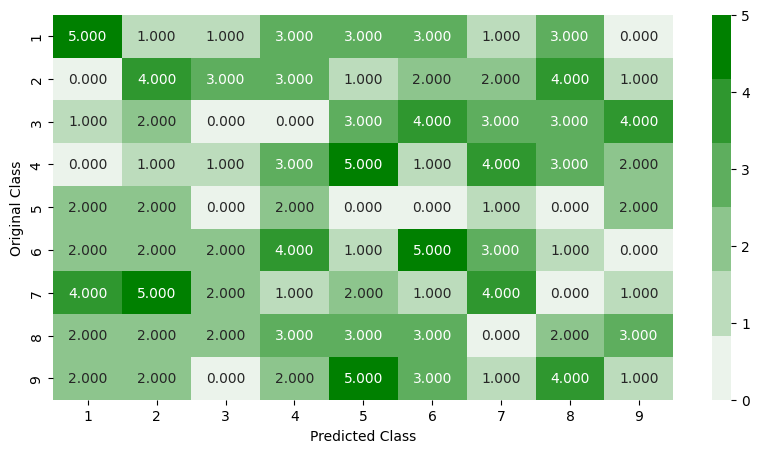

-------------------------------------------------- Precision matrix --------------------------------------------------


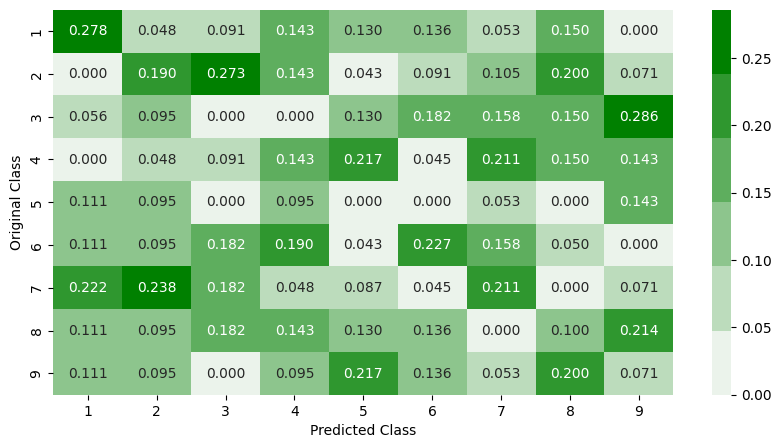

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


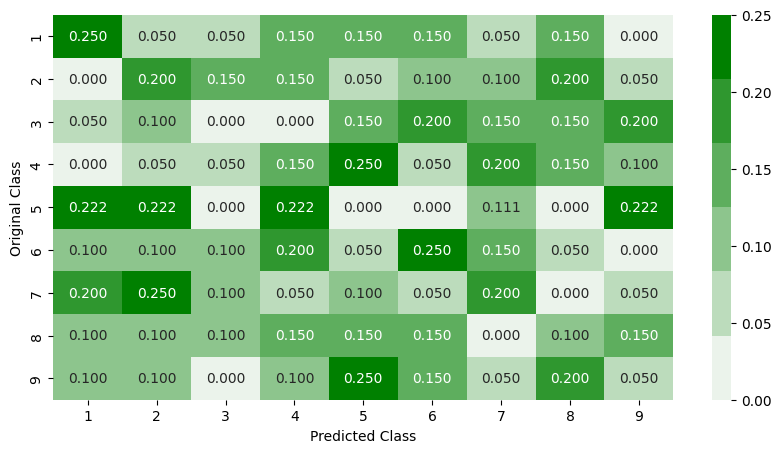

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [22]:

# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

11- K Nearest Neighbour Classification ONLY on bytes files

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for k =  1 is 0.4524909857905779
log_loss for k =  3 is 0.5200679012907584
log_loss for k =  5 is 0.564725413884266
log_loss for k =  7 is 0.5926076277604654
log_loss for k =  9 is 0.6311977380580656
log_loss for k =  11 is 0.666513783401215
log_loss for k =  13 is 0.6845409478298898


C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


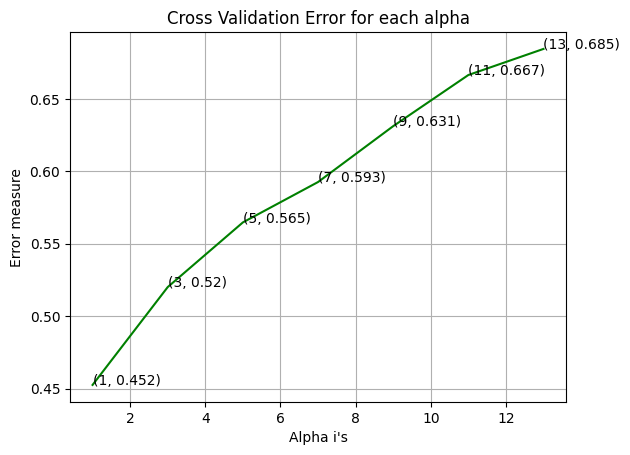

For values of best alpha =  1 The train log loss is: 0.2408531522949627
For values of best alpha =  1 The cross validation log loss is: 0.4524909857905779
For values of best alpha =  1 The test log loss is: 0.5429829040943113
Number of misclassified points  10.650887573964498
-------------------------------------------------- Confusion matrix --------------------------------------------------


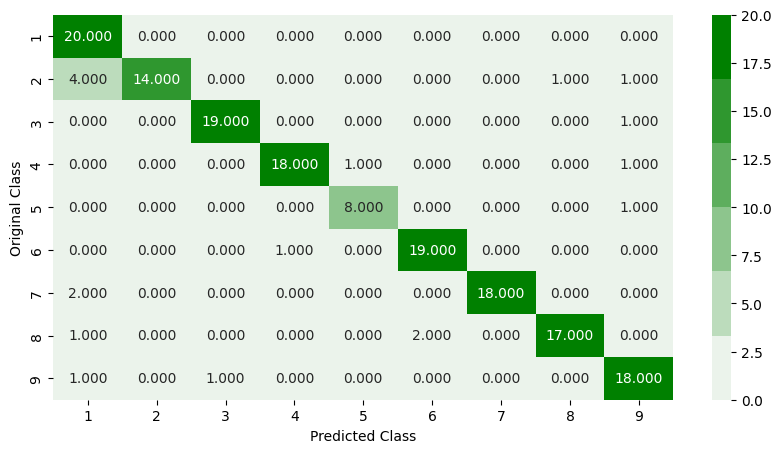

-------------------------------------------------- Precision matrix --------------------------------------------------


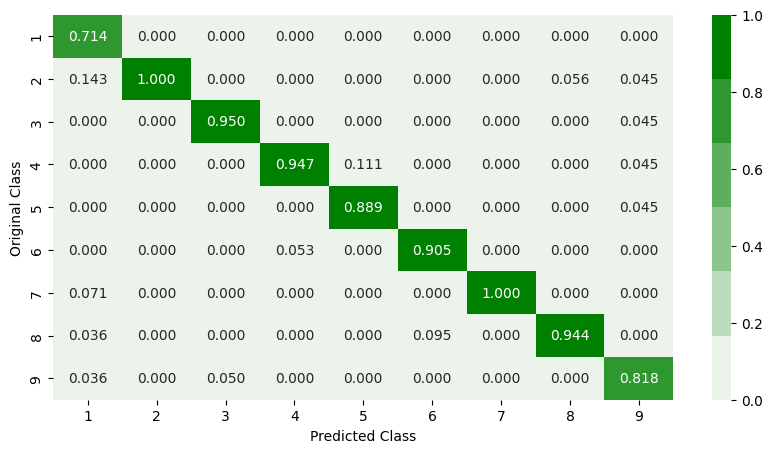

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


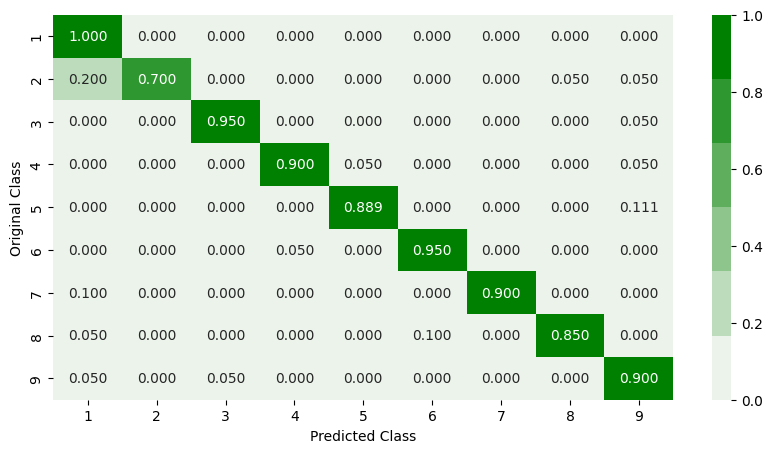

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [23]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.

# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification

  
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

12- Logistic Regression ONLY on bytes files

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for c =  1e-05 is 1.2112828523500179
log_loss for c =  0.0001 is 1.2104318786562038
log_loss for c =  0.001 is 1.204897970594485
log_loss for c =  0.01 is 1.151974789859116
log_loss for c =  0.1 is 1.1191281587462965
log_loss for c =  1 is 1.0597262824928568
log_loss for c =  10 is 0.9237269574633817
log_loss for c =  100 is 0.9126255982641772
log_loss for c =  1000 is 0.9719441670389204


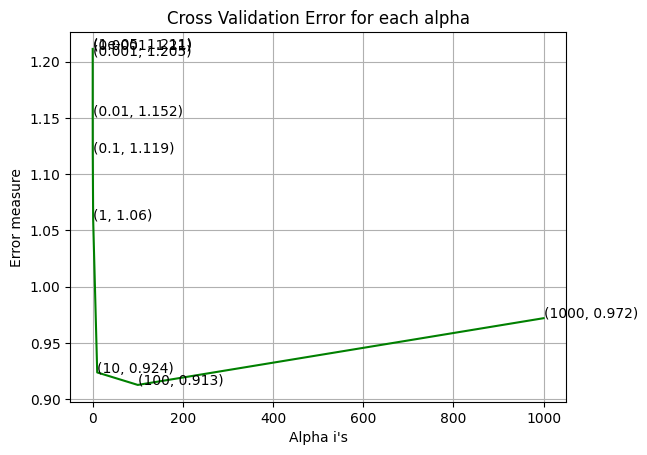

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

log loss for train data 0.9100400544505726
log loss for cv data 0.9126255982641772
log loss for test data 1.0223729105600265
Number of misclassified points  20.118343195266274
-------------------------------------------------- Confusion matrix --------------------------------------------------


C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Temp\ipykernel_3024\911810118.py:22: RuntimeWarning: invalid value encountered in divide
  B =(C/C.sum(axis=0))


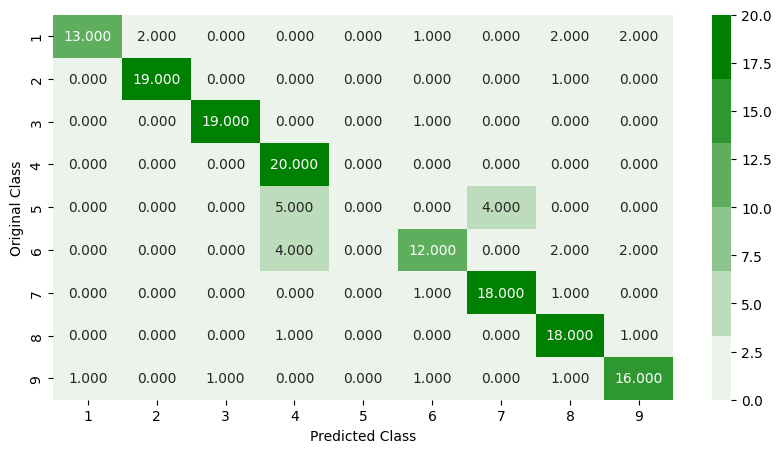

-------------------------------------------------- Precision matrix --------------------------------------------------


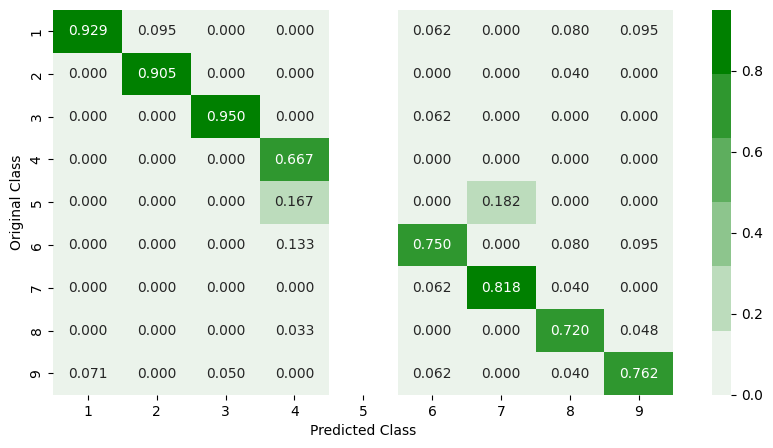

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


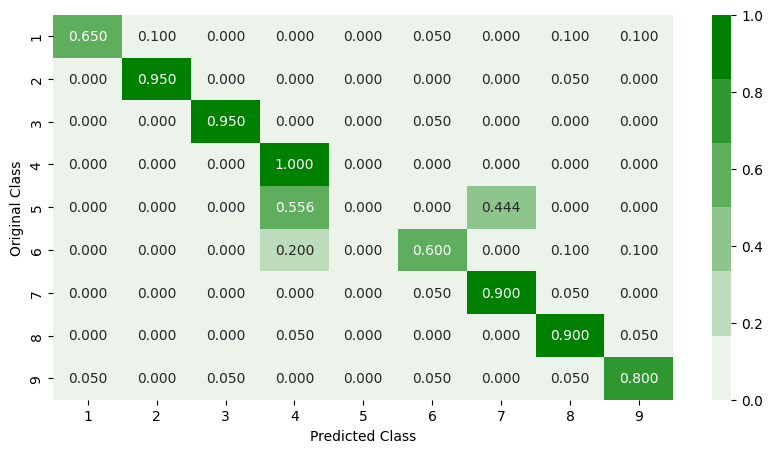

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [24]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

13- Random Forest Classifier ONLY on bytes files

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for c =  10 is 0.33142330154174915
log_loss for c =  50 is 0.29370973471638695
log_loss for c =  100 is 0.2860553674777525
log_loss for c =  500 is 0.29199313722292786
log_loss for c =  1000 is 0.2894257279823216
log_loss for c =  2000 is 0.28970538288857206
log_loss for c =  3000 is 0.28968293724496186


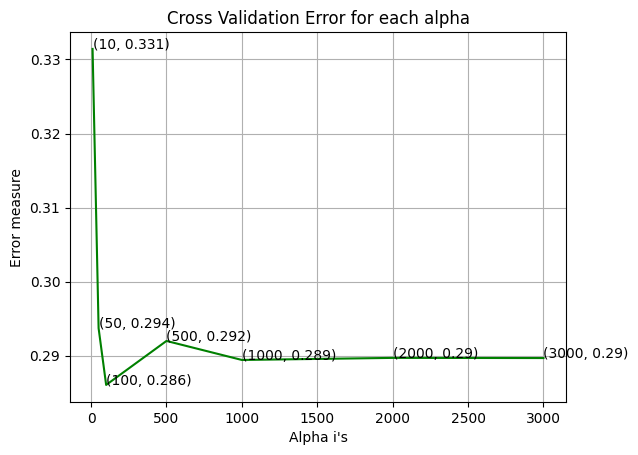

For values of best alpha =  100 The train log loss is: 0.14892390308990433
For values of best alpha =  100 The cross validation log loss is: 0.2860553674777525
For values of best alpha =  100 The test log loss is: 0.3660485425064585
Number of misclassified points  6.508875739644971
-------------------------------------------------- Confusion matrix --------------------------------------------------


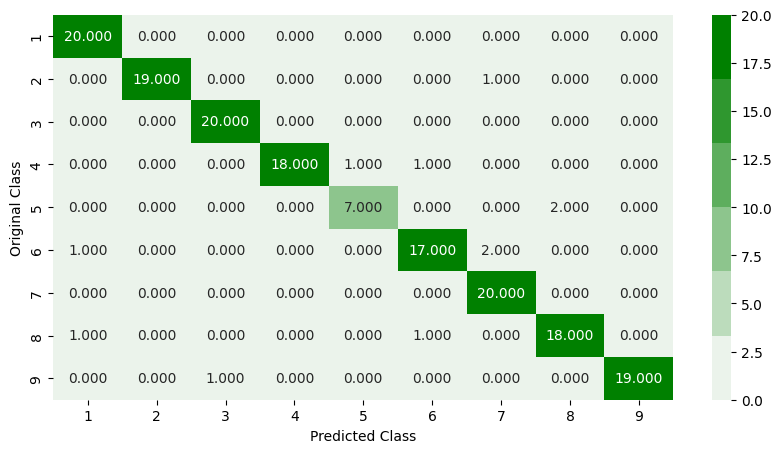

-------------------------------------------------- Precision matrix --------------------------------------------------


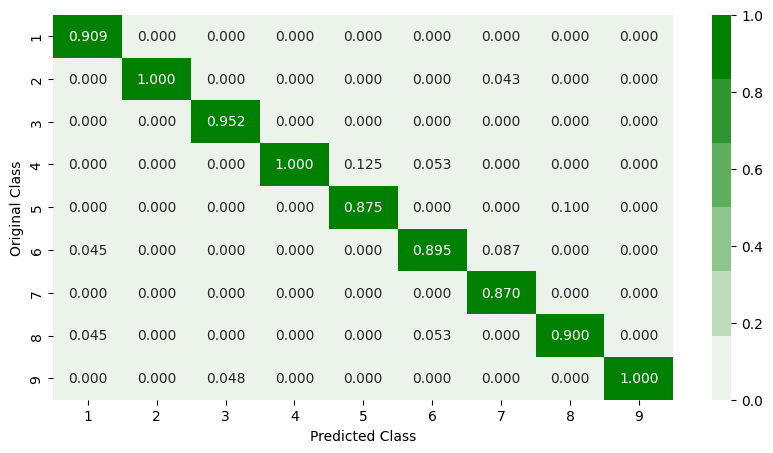

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


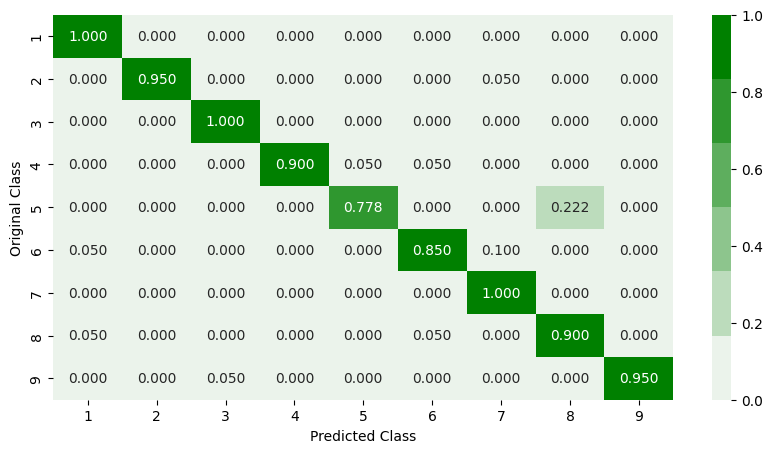

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [25]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

14 -XgBoost Classification only on bytes files

Classes in training set: [0 1 2]
Classes in validation set: [0 1 2]
Classes in test set: [0 1 2]


C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for c =  10 is 0.20315910855278824
log_loss for c =  50 is 0.19635347957871419
log_loss for c =  100 is 0.19623344479771718
log_loss for c =  500 is 0.20197161997755267
log_loss for c =  1000 is 0.2030059888828769
log_loss for c =  2000 is 0.2037212657943059


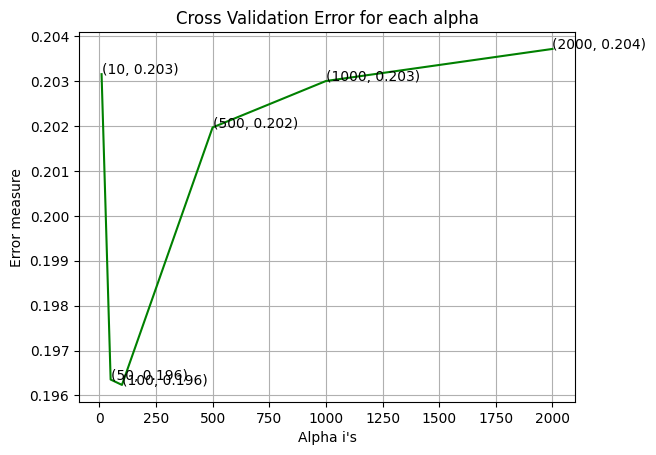

For values of best alpha =  100 The train log loss is: 0.20482982637755456
For values of best alpha =  100 The cross validation log loss is: 0.19623344479771718
For values of best alpha =  100 The test log loss is: 0.1867245922322573


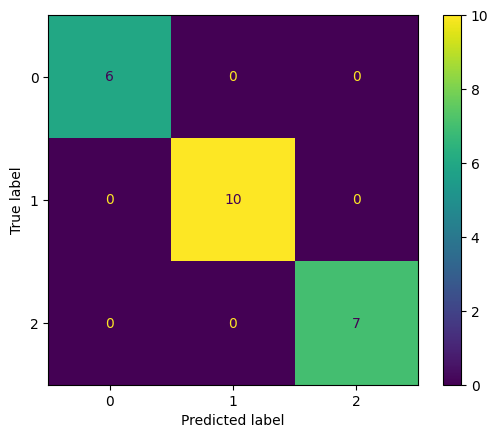

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Load a sample dataset
data = load_iris()
X = data.data
y = data.target

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Ensure the classes are consistent across splits
classes = np.unique(y_train)
print("Classes in training set:", classes)
print("Classes in validation set:", np.unique(y_cv))
print("Classes in test set:", np.unique(y_test))

alpha = [10, 50, 100, 500, 1000, 2000]
cv_log_error_array = []

for i in alpha:
    x_cfl = XGBClassifier(n_estimators=i, nthread=-1)
    x_cfl.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print('log_loss for c = ', alpha[i], 'is', cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array, c='g')
for i, txt in enumerate(np.round(cv_log_error_array, 3)):
    ax.annotate((alpha[i], np.round(txt, 3)), (alpha[i], cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl = XGBClassifier(n_estimators=alpha[best_alpha], nthread=-1)
x_cfl.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:", log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:", log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:", log_loss(y_test, predict_y))

ConfusionMatrixDisplay.from_estimator(sig_clf, X_test, y_test)
plt.show()


15 - XgBoost Classification with best hyper parameters using RandomSearch Obly on Bytes files

In [27]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   verbose=10)

In [28]:
print (random_cfl1.best_params_)

{'subsample': 0.5, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1}


In [29]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance


x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.05, colsample_bytree=1, max_depth=3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 0.20843980864780817
cv loss 0.19939743292494416
test loss 0.19137788633962072


Modeling with .asm files 

16- Feature extraction from asm files 

In [30]:
# import os
# import pandas as pd
# import numpy as np
# import codecs
# import shutil
# import random as r
# from multiprocessing import Process, Manager

# # Setup logging
# import logging
# logging.basicConfig(filename='process_logs.log', level=logging.DEBUG, format='%(asctime)s %(levelname)s:%(message)s')

# def setup_folders():
#     folder_names = ['first', 'second', 'third', 'fourth', 'fifth', 'output']
#     for folder in folder_names:
#         os.makedirs(folder, exist_ok=True)
#         logging.info(f'Folder {folder} created or already exists.')

# def distribute_files():
#     source = 'trainAsm/'
#     if not os.path.exists(source):
#         logging.error(f'Source directory {source} does not exist.')
#         return
#     files = os.listdir(source)
#     if not files:
#         logging.error('No files found in the source directory.')
#         return
#     data = list(range(len(files)))
#     r.shuffle(data)
#     folder_names = ['first', 'second', 'third', 'fourth', 'fifth']
#     for i, file_index in enumerate(data):
#         file = files[file_index]
#         dest_folder = folder_names[i % 5]
#         shutil.move(os.path.join(source, file), dest_folder)
#         logging.info(f'Moved {file} to {dest_folder}.')

# def process_asm_files(folder_name, output_file_name):
#     try:
#         file_path = os.path.join('output', output_file_name)
#         files = os.listdir(folder_name)
#         if not files:
#             logging.warning(f'No files to process in {folder_name}.')
#             return
#         with open(file_path, "w+") as file1:
#             for f in files:
#                 process_file(f, folder_name, file1)
#             logging.info(f'Features written to {output_file_name}.')
#     except Exception as e:
#         logging.error(f'Error processing files in {folder_name}: {e}')

# def process_file(f, folder_name, file1):
#     # Insert the contents of your feature extraction function here, ending with file1.write() as in the previous example
#     pass

# def main():
#     setup_folders()
#     distribute_files()
#     process_args = [
#         ('first', 'asmsmallfile.txt'),
#         ('second', 'mediumasmfile.txt'),
#         ('third', 'largeasmfile.txt'),
#         ('fourth', 'hugeasmfile.txt'),
#         ('fifth', 'trainasmfile.txt')
#     ]
#     processes = [Process(target=process_asm_files, args=args) for args in process_args]
#     for p in processes:
#         p.start()
#     for p in processes:
#         p.join()

# if __name__ == "__main__":
#     main()

# # Include this function in your main script if needed to load and merge features
# def load_and_merge_features():
#     try:
#         dfasm = pd.read_csv("output/asmoutputfile.csv")
#         Y = pd.read_csv("trainLabels.csv")
#         Y.columns = ['ID', 'Class']
#         result_asm = pd.merge(dfasm, Y, on='ID', how='left')
#         print(result_asm.head())
#     except Exception as e:
#         logging.error(f'Failed to load and merge features: {e}')


In [31]:
# import os
# import shutil
# import random

# # Define folder names
# folder_1 = 'first'
# folder_2 = 'second'
# folder_3 = 'third'
# folder_4 = 'fourth'
# folder_5 = 'fifth'
# folder_6 = 'output'

# # Create folders if they don't exist
# for folder in [folder_1, folder_2, folder_3, folder_4, folder_5, folder_6]:
#     if not os.path.isdir(folder):
#         os.makedirs(folder)

# # Source folder containing files
# source = 'trainAsm'

# # List of files in the source folder
# files = os.listdir(source)

# # Generate a list of indices for shuffling
# data = list(range(len(files)))
# random.shuffle(data)

# # Move files into the respective folders
# for i in range(len(files)):
#     if i % 5 == 0:
#         shutil.move(os.path.join(source, files[data[i]]), folder_1)
#     elif i % 5 == 1:
#         shutil.move(os.path.join(source, files[data[i]]), folder_2)
#     elif i % 5 == 2:
#         shutil.move(os.path.join(source, files[data[i]]), folder_3)
#     elif i % 5 == 3:
#         shutil.move(os.path.join(source, files[data[i]]), folder_4)
#     elif i % 5 == 4:
#         shutil.move(os.path.join(source, files[data[i]]), folder_5)


In [32]:
# import os
# import shutil
# import random
# import numpy as np
# import codecs
# from multiprocessing import Process

# def firstprocess():
#     prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
#     opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add', 'imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb', 'jz', 'rtn', 'lea', 'movzx']
#     keywords = ['.dll', 'std::', ':dword']
#     registers = ['edx', 'esi', 'eax', 'ebx', 'ecx', 'edi', 'ebp', 'esp', 'eip']
#     with open("output/asmsmallfile.txt", "w+") as file1:
#         files = os.listdir('first')
#         for f in files:
#             prefixescount = np.zeros(len(prefixes), dtype=int)
#             opcodescount = np.zeros(len(opcodes), dtype=int)
#             keywordcount = np.zeros(len(keywords), dtype=int)
#             registerscount = np.zeros(len(registers), dtype=int)
#             features = []
#             f2 = f.split('.')[0]
#             file1.write(f2 + ",")
#             with codecs.open('first/' + f, encoding='cp1252', errors='replace') as fli:
#                 for lines in fli:
#                     line = lines.rstrip().split()
#                     l = line[0]
#                     for i in range(len(prefixes)):
#                         if prefixes[i] in line[0]:
#                             prefixescount[i] += 1
#                     line = line[1:]
#                     for i in range(len(opcodes)):
#                         if any(opcodes[i] == li for li in line):
#                             features.append(opcodes[i])
#                             opcodescount[i] += 1
#                     for i in range(len(registers)):
#                         for li in line:
#                             if registers[i] in li and ('text' in l or 'CODE' in l):
#                                 registerscount[i] += 1
#                     for i in range(len(keywords)):
#                         for li in line:
#                             if keywords[i] in li:
#                                 keywordcount[i] += 1
#             for prefix in prefixescount:
#                 file1.write(str(prefix) + ",")
#             for opcode in opcodescount:
#                 file1.write(str(opcode) + ",")
#             for register in registerscount:
#                 file1.write(str(register) + ",")
#             for key in keywordcount:
#                 file1.write(str(key) + ",")
#             file1.write("\n")


# def secondprocess():
#     prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
#     opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add', 'imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb', 'jz', 'rtn', 'lea', 'movzx']
#     keywords = ['.dll', 'std::', ':dword']
#     registers = ['edx', 'esi', 'eax', 'ebx', 'ecx', 'edi', 'ebp', 'esp', 'eip']
#     with open("output/mediumasmfile.txt", "w+") as file1:
#         files = os.listdir('second')
#         for f in files:
#             prefixescount = np.zeros(len(prefixes), dtype=int)
#             opcodescount = np.zeros(len(opcodes), dtype=int)
#             keywordcount = np.zeros(len(keywords), dtype=int)
#             registerscount = np.zeros(len(registers), dtype=int)
#             features = []
#             f2 = f.split('.')[0]
#             file1.write(f2 + ",")
#             with codecs.open('second/' + f, encoding='cp1252', errors='replace') as fli:
#                 for lines in fli:
#                     line = lines.rstrip().split()
#                     l = line[0]
#                     for i in range(len(prefixes)):
#                         if prefixes[i] in line[0]:
#                             prefixescount[i] += 1
#                     line = line[1:]
#                     for i in range(len(opcodes)):
#                         if any(opcodes[i] == li for li in line):
#                             features.append(opcodes[i])
#                             opcodescount[i] += 1
#                     for i in range(len(registers)):
#                         for li in line:
#                             if registers[i] in li and ('text' in l or 'CODE' in l):
#                                 registerscount[i] += 1
#                     for i in range(len(keywords)):
#                         for li in line:
#                             if keywords[i] in li:
#                                 keywordcount[i] += 1
#             for prefix in prefixescount:
#                 file1.write(str(prefix) + ",")
#             for opcode in opcodescount:
#                 file1.write(str(opcode) + ",")
#             for register in registerscount:
#                 file1.write(str(register) + ",")
#             for key in keywordcount:
#                 file1.write(str(key) + ",")
#             file1.write("\n")


# def thirdprocess():
#     prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
#     opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add', 'imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb', 'jz', 'rtn', 'lea', 'movzx']
#     keywords = ['.dll', 'std::', ':dword']
#     registers = ['edx', 'esi', 'eax', 'ebx', 'ecx', 'edi', 'ebp', 'esp', 'eip']
#     with open("output/largeasmfile.txt", "w+") as file1:
#         files = os.listdir('third')
#         for f in files:
#             prefixescount = np.zeros(len(prefixes), dtype=int)
#             opcodescount = np.zeros(len(opcodes), dtype=int)
#             keywordcount = np.zeros(len(keywords), dtype=int)
#             registerscount = np.zeros(len(registers), dtype=int)
#             features = []
#             f2 = f.split('.')[0]
#             file1.write(f2 + ",")
#             with codecs.open('third/' + f, encoding='cp1252', errors='replace') as fli:
#                 for lines in fli:
#                     line = lines.rstrip().split()
#                     l = line[0]
#                     for i in range(len(prefixes)):
#                         if prefixes[i] in line[0]:
#                             prefixescount[i] += 1
#                     line = line[1:]
#                     for i in range(len(opcodes)):
#                         if any(opcodes[i] == li for li in line):
#                             features.append(opcodes[i])
#                             opcodescount[i] += 1
#                     for i in range(len(registers)):
#                         for li in line:
#                             if registers[i] in li and ('text' in l or 'CODE' in l):
#                                 registerscount[i] += 1
#                     for i in range(len(keywords)):
#                         for li in line:
#                             if keywords[i] in li:
#                                 keywordcount[i] += 1
#             for prefix in prefixescount:
#                 file1.write(str(prefix) + ",")
#             for opcode in opcodescount:
#                 file1.write(str(opcode) + ",")
#             for register in registerscount:
#                 file1.write(str(register) + ",")
#             for key in keywordcount:
#                 file1.write(str(key) + ",")
#             file1.write("\n")


# def fourthprocess():
#     prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
#     opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add', 'imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb', 'jz', 'rtn', 'lea', 'movzx']
#     keywords = ['.dll', 'std::', ':dword']
#     registers = ['edx', 'esi', 'eax', 'ebx', 'ecx', 'edi', 'ebp', 'esp', 'eip']
#     with open("output/hugeasmfile.txt", "w+") as file1:
#         files = os.listdir('fourth')
#         for f in files:
#             prefixescount = np.zeros(len(prefixes), dtype=int)
#             opcodescount = np.zeros(len(opcodes), dtype=int)
#             keywordcount = np.zeros(len(keywords), dtype=int)
#             registerscount = np.zeros(len(registers), dtype=int)
#             features = []
#             f2 = f.split('.')[0]
#             file1.write(f2 + ",")
#             with codecs.open('fourth/' + f, encoding='cp1252', errors='replace') as fli:
#                 for lines in fli:
#                     line = lines.rstrip().split()
#                     l = line[0]
#                     for i in range(len(prefixes)):
#                         if prefixes[i] in line[0]:
#                             prefixescount[i] += 1
#                     line = line[1:]
#                     for i in range(len(opcodes)):
#                         if any(opcodes[i] == li for li in line):
#                             features.append(opcodes[i])
#                             opcodescount[i] += 1
#                     for i in range(len(registers)):
#                         for li in line:
#                             if registers[i] in li and ('text' in l or 'CODE' in l):
#                                 registerscount[i] += 1
#                     for i in range(len(keywords)):
#                         for li in line:
#                             if keywords[i] in li:
#                                 keywordcount[i] += 1
#             for prefix in prefixescount:
#                 file1.write(str(prefix) + ",")
#             for opcode in opcodescount:
#                 file1.write(str(opcode) + ",")
#             for register in registerscount:
#                 file1.write(str(register) + ",")
#             for key in keywordcount:
#                 file1.write(str(key) + ",")
#             file1.write("\n")


# def fifthprocess():
#     prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
#     opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add', 'imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb', 'jz', 'rtn', 'lea', 'movzx']
#     keywords = ['.dll', 'std::', ':dword']
#     registers = ['edx', 'esi', 'eax', 'ebx', 'ecx', 'edi', 'ebp', 'esp', 'eip']
#     with open("output/trainasmfile.txt", "w+") as file1:
#         files = os.listdir('fifth')
#         for f in files:
#             prefixescount = np.zeros(len(prefixes), dtype=int)
#             opcodescount = np.zeros(len(opcodes), dtype=int)
#             keywordcount = np.zeros(len(keywords), dtype=int)
#             registerscount = np.zeros(len(registers), dtype=int)
#             features = []
#             f2 = f.split('.')[0]
#             file1.write(f2 + ",")
#             with codecs.open('fifth/' + f, encoding='cp1252', errors='replace') as fli:
#                 for lines in fli:
#                     line = lines.rstrip().split()
#                     l = line[0]
#                     for i in range(len(prefixes)):
#                         if prefixes[i] in line[0]:
#                             prefixescount[i] += 1
#                     line = line[1:]
#                     for i in range(len(opcodes)):
#                         if any(opcodes[i] == li for li in line):
#                             features.append(opcodes[i])
#                             opcodescount[i] += 1
#                     for i in range(len(registers)):
#                         for li in line:
#                             if registers[i] in li and ('text' in l or 'CODE' in l):
#                                 registerscount[i] += 1
#                     for i in range(len(keywords)):
#                         for li in line:
#                             if keywords[i] in li:
#                                 keywordcount[i] += 1
#             for prefix in prefixescount:
#                 file1.write(str(prefix) + ",")
#             for opcode in opcodescount:
#                 file1.write(str(opcode) + ",")
#             for register in registerscount:
#                 file1.write(str(register) + ",")
#             for key in keywordcount:
#                 file1.write(str(key) + ",")
#             file1.write("\n")


# def main():
#     p1 = Process(target=firstprocess)
#     p2 = Process(target=secondprocess)
#     p3 = Process(target=thirdprocess)
#     p4 = Process(target=fourthprocess)
#     p5 = Process(target=fifthprocess)
#     p1.start()
#     p2.start()
#     p3.start()
#     p4.start()
#     p5.start()
#     p1.join()
#     p2.join()
#     p3.join()
#     p4.join()
#     p5.join()

# if __name__ == "__main__":
#     main()


In [74]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# we will use this file directly
dfasm=pd.read_csv("df_features_3_labelled.csv")
# Y.columns = ['ID', 'Class']
# result_asm = pd.merge(dfasm, Y,on='ID', how='left')
# result_asm.head()   
dfasm

,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,7,18717,0,253,688307,0,1223,0,0,0,...,1491,1903,4366,800,2316,1285,581,688,0,8
1,0,103812,0,214,11197,0,11720,0,0,0,...,713,481,1398,254,1063,383,904,415,0,1
2,7,68554,0,123,439,0,588,0,0,0,...,524,4,942,5,546,7,451,56,0,8
3,8,568,0,28,33,0,155,0,1,0,...,20,31,125,17,64,13,41,79,0,0
4,7,8851,0,76,2058,76,0,0,1,0,...,1037,24,1129,18,1144,24,1545,107,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
837,7,3174,0,88,1268,0,2644,2,1,0,...,316,505,651,346,316,310,349,39,0,4
838,8,5427,0,131,8918,0,330,0,1,0,...,459,298,1310,246,668,450,1332,383,0,4
839,7,0,0,82,0,0,10,0,1,6,...,89,48,183,60,74,15,93,44,0,4
840,7,3037,0,62,1885,0,4589,0,1,0,...,224,589,667,271,238,227,380,61,0,4


17- Files sizes of each .asm file as a feature 

In [75]:
# file sizes of asm files

files=os.listdir('trainAsm')
filenames=Y['ID'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('trainAsm/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

                     ID       size  Class
0  01azqd4InC7m9JpocGv5  56.229886      9
1  01IsoiSMh5gxyDYTl4CB  13.999378      2
2  01jsnpXSAlgw6aPeDxrU   8.507785      9
3  01kcPWA9K2BOxQeS5Rju   0.078190      1
4  01SuzwMJEIXsK7A8dQbl   0.996723      8


18- Distribution of .asm file sizes

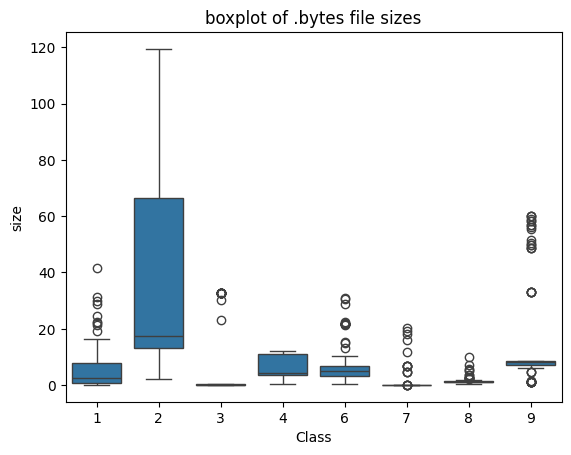

In [76]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [77]:
# add the file size feature to previous extracted features
print(dfasm.shape)


(842, 41)


In [78]:
# we normalize the data each column 
result_asm = normalize(dfasm)
result_asm.head()

,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,.tls:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,0.466667,0.033174,0.0,0.075953,0.933815,0.000000,0.000827,0.0,0.000000,0.0,...,0.031079,0.025314,0.036207,0.020143,0.027120,0.029857,0.007144,0.012140,0.0,8
1,0.000000,0.183995,0.0,0.064245,0.015191,0.000000,0.007924,0.0,0.000000,0.0,...,0.014862,0.006398,0.011594,0.006395,0.012448,0.008899,0.011115,0.007323,0.0,1
2,0.466667,0.121504,0.0,0.036926,0.000596,0.000000,0.000398,0.0,0.000000,0.0,...,0.010922,0.000053,0.007812,0.000126,0.006394,0.000163,0.005545,0.000988,0.0,8
3,0.533333,0.001007,0.0,0.008406,0.000045,0.000000,0.000105,0.0,0.000066,0.0,...,0.000417,0.000412,0.001037,0.000428,0.000749,0.000302,0.000504,0.001394,0.0,0
4,0.466667,0.015687,0.0,0.022816,0.002792,0.010632,0.000000,0.0,0.000066,0.0,...,0.021615,0.000319,0.009363,0.000453,0.013396,0.000558,0.018996,0.001888,0.0,7


19- Univariate analysis ONLY on .asm file features 

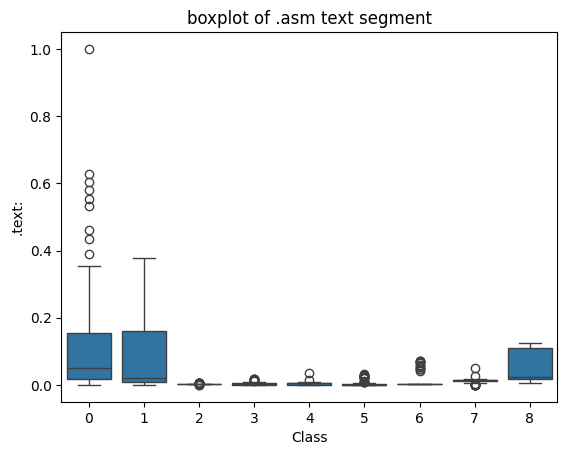

In [79]:
ax = sns.boxplot(x="Class", y=".text:", data=result_asm)
plt.title("boxplot of .asm text segment")
plt.show()

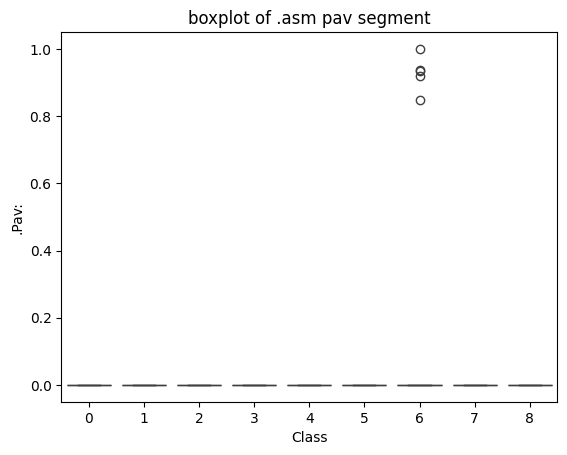

In [80]:
ax = sns.boxplot(x="Class", y=".Pav:", data=result_asm)
plt.title("boxplot of .asm pav segment")
plt.show()

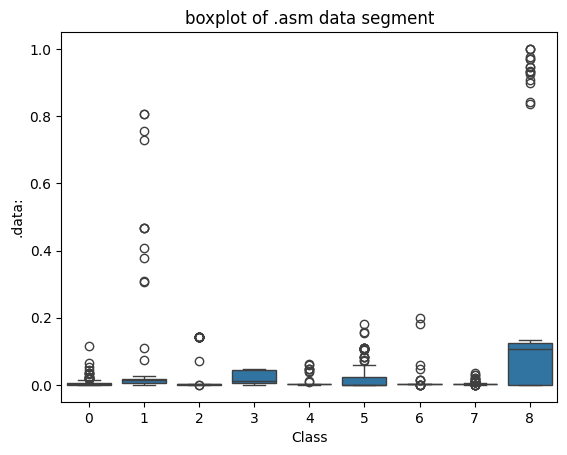

In [81]:
ax = sns.boxplot(x="Class", y=".data:", data=result_asm)
plt.title("boxplot of .asm data segment")
plt.show()

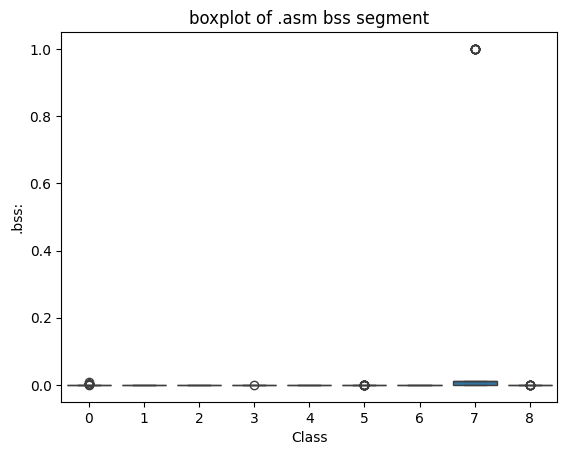

In [82]:
ax = sns.boxplot(x="Class", y=".bss:", data=result_asm)
plt.title("boxplot of .asm bss segment")
plt.show()

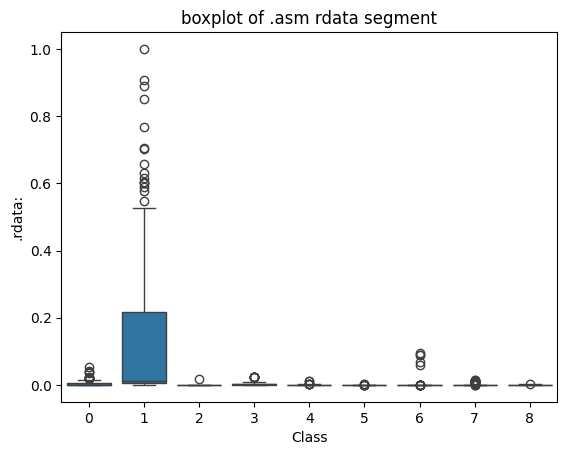

In [83]:
ax = sns.boxplot(x="Class", y=".rdata:", data=result_asm)
plt.title("boxplot of .asm rdata segment")
plt.show()

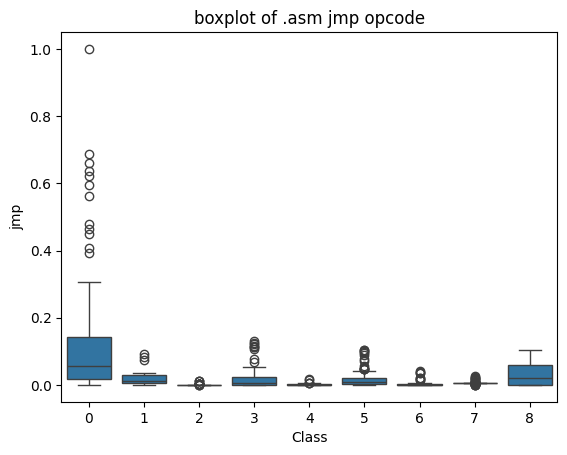

In [84]:
ax = sns.boxplot(x="Class", y="jmp", data=result_asm)
plt.title("boxplot of .asm jmp opcode")
plt.show()

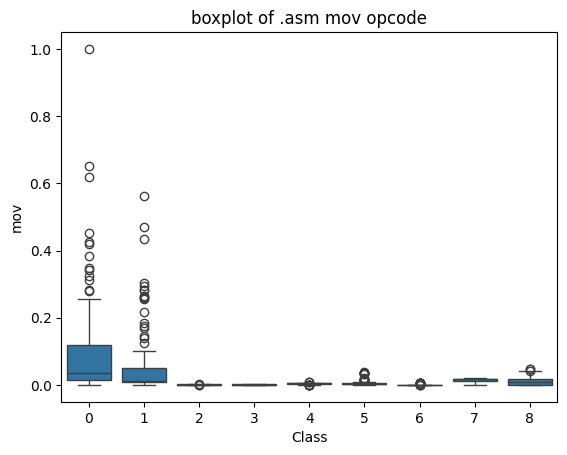

In [85]:
ax = sns.boxplot(x="Class", y="mov", data=result_asm)
plt.title("boxplot of .asm mov opcode")
plt.show()

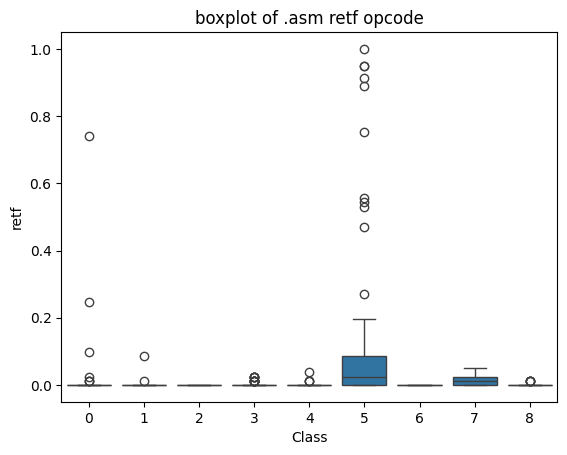

In [86]:
ax = sns.boxplot(x="Class", y="retf", data=result_asm)
plt.title("boxplot of .asm retf opcode")
plt.show()

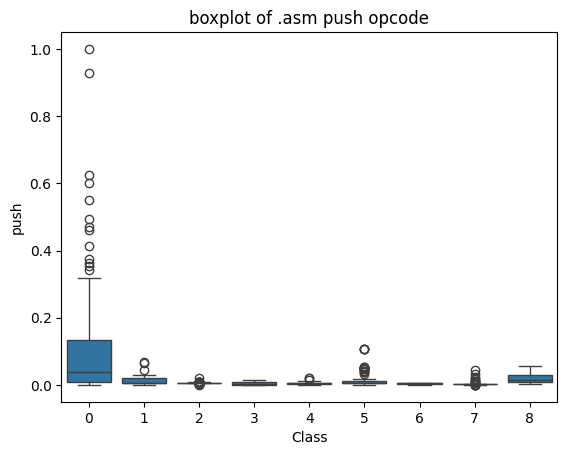

In [87]:
ax = sns.boxplot(x="Class", y="push", data=result_asm)
plt.title("boxplot of .asm push opcode")
plt.show()

20- Multivariate Analysis ONLY on .asm file features 

C:\Users\youse\AppData\Local\Temp\ipykernel_3024\280109668.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))


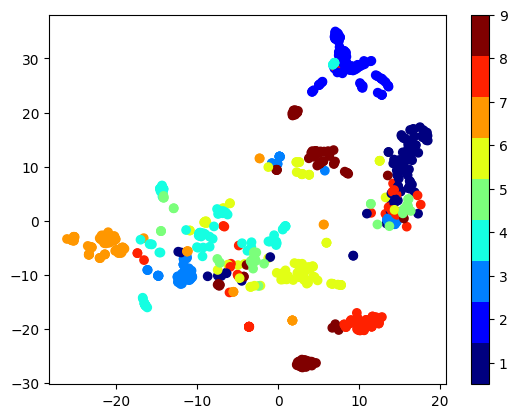

In [88]:
#multivariate analysis on asm files
#this is with perplexity 50
xtsne=TSNE(perplexity=50)
results=xtsne.fit_transform(result_asm.drop(['Class'], axis=1).fillna(0))

vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

C:\Users\youse\AppData\Local\Temp\ipykernel_3024\3398271131.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))


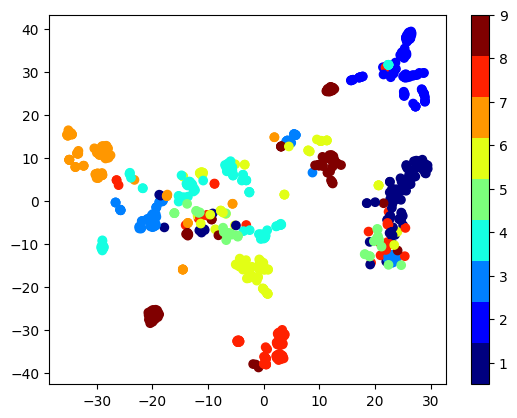

In [89]:
# by univariate analysis on the .asm file features we are getting very negligible information from 
# 'rtn', '.BSS:' '.CODE' features, so heare we are trying multivariate analysis after removing those features
# the plot looks very messy

xtsne=TSNE(perplexity=30)
results=xtsne.fit_transform(result_asm.drop(['Class', '.BSS:', '.CODE'], axis=1))
vis_x = results[:, 0]
vis_y = results[:, 1]
plt.scatter(vis_x, vis_y, c=data_y, cmap=plt.cm.get_cmap("jet", 9))
plt.colorbar(ticks=range(10))
plt.clim(0.5, 9)
plt.show()

21- Train and test split ( ONLY on .asm file featues ) 

In [90]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['Class','.BSS:','.CODE'], axis=1)

In [91]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [92]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
.bss:      False
.rdata:    False
.edata:    False
.rsrc:     False
.tls:      False
.reloc:    False
jmp        False
mov        False
retf       False
push       False
pop        False
xor        False
ret        False
nop        False
sub        False
inc        False
dec        False
add        False
imul       False
xchg       False
or         False
shr        False
cmp        False
call       False
edx        False
esi        False
eax        False
ebx        False
ecx        False
edi        False
ebp        False
esp        False
eip        False
dtype: bool


27- K-Nearest Neigbors ONLY on .asm file features 


C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for k =  1 is 0.48128203732109365
log_loss for k =  3 is 0.47260691299659147
log_loss for k =  5 is 0.49529806072907134
log_loss for k =  7 is 0.5422275542066471
log_loss for k =  9 is 0.58536346380469
log_loss for k =  11 is 0.6161638999631838
log_loss for k =  13 is 0.6361558929989071
log_loss for k =  15 is 0.6415917767404065
log_loss for k =  17 is 0.6544730727959128
log_loss for k =  19 is 0.6717040307493969


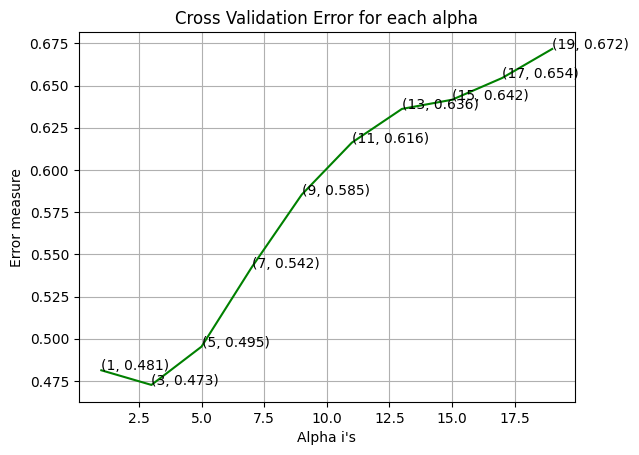

log loss for train data 0.23532171423417927
log loss for cv data 0.47260691299659147
log loss for test data 0.368030924070769
Number of misclassified points  7.6923076923076925
-------------------------------------------------- Confusion matrix --------------------------------------------------


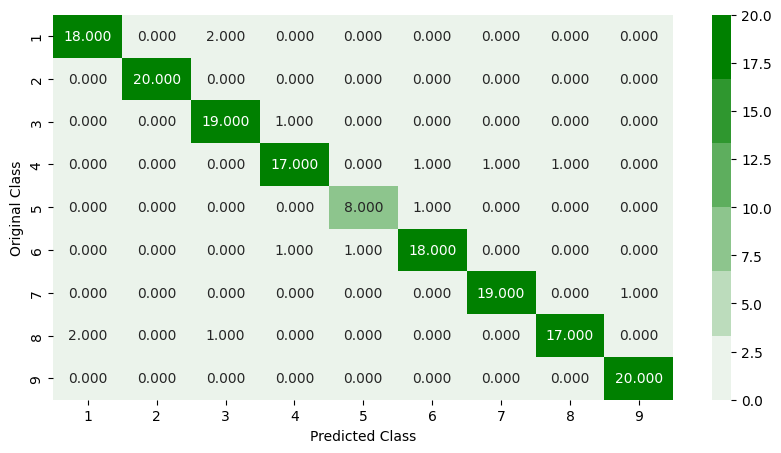

-------------------------------------------------- Precision matrix --------------------------------------------------


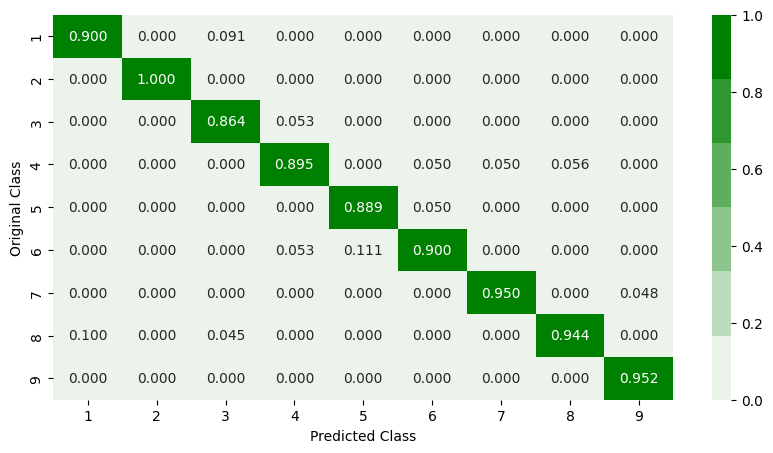

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


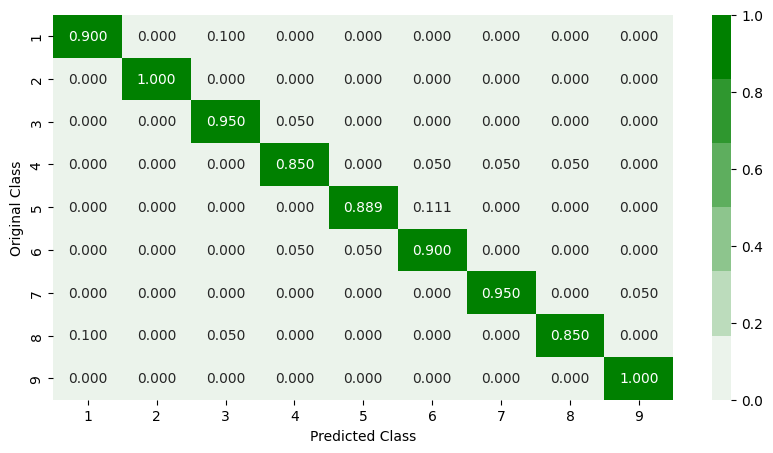

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [93]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification


alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

22- Logistic Regression ONLY on .asm file features

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for c =  1e-05 is 1.485982743012906
log_loss for c =  0.0001 is 1.4859827354971276
log_loss for c =  0.001 is 1.485552873891256
log_loss for c =  0.01 is 1.4829979736414622
log_loss for c =  0.1 is 1.4542125549325566
log_loss for c =  1 is 1.4109885322490885
log_loss for c =  10 is 1.4962825329842602
log_loss for c =  100 is 1.5954629274412835
log_loss for c =  1000 is 1.5635597832215935


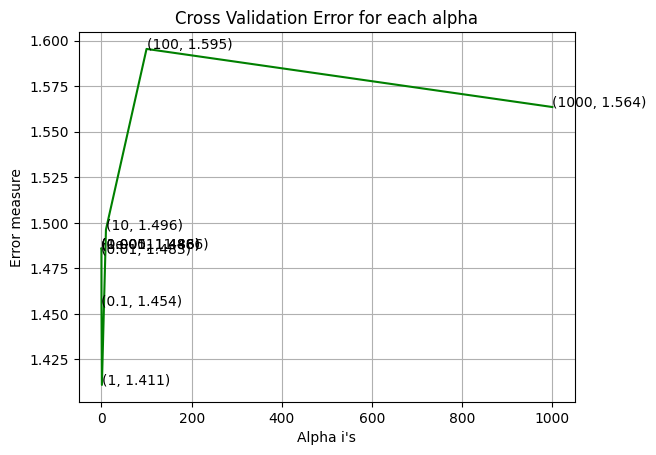

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log loss for train data 1.3226239889085374
log loss for cv data 1.4109885322490885
log loss for test data 1.3836599019263733
Number of misclassified points  40.23668639053255
-------------------------------------------------- Confusion matrix --------------------------------------------------


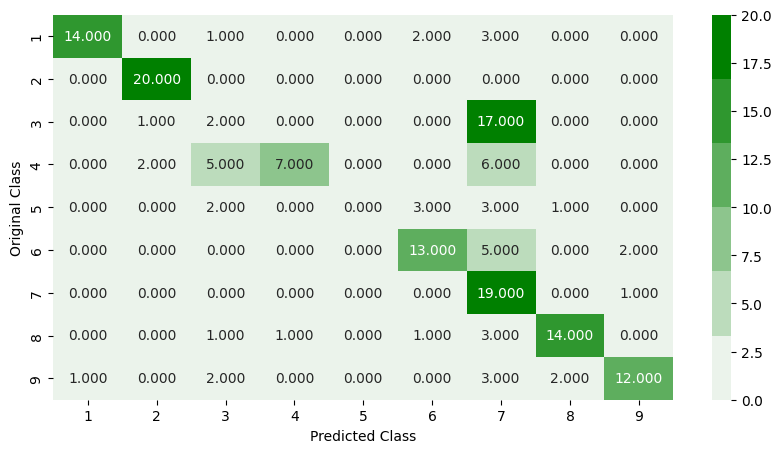

-------------------------------------------------- Precision matrix --------------------------------------------------


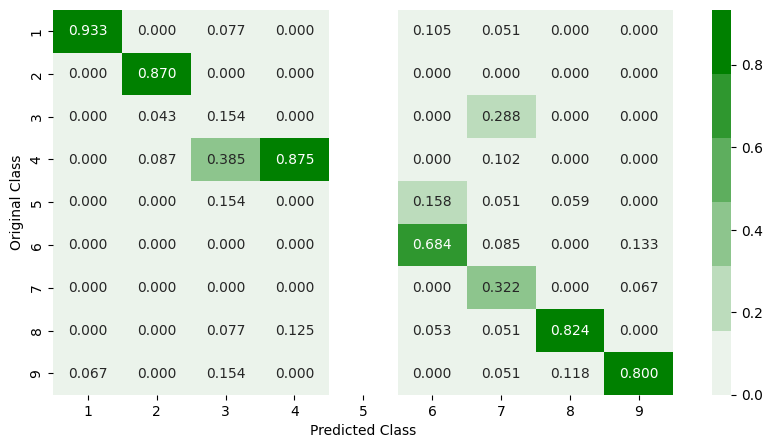

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


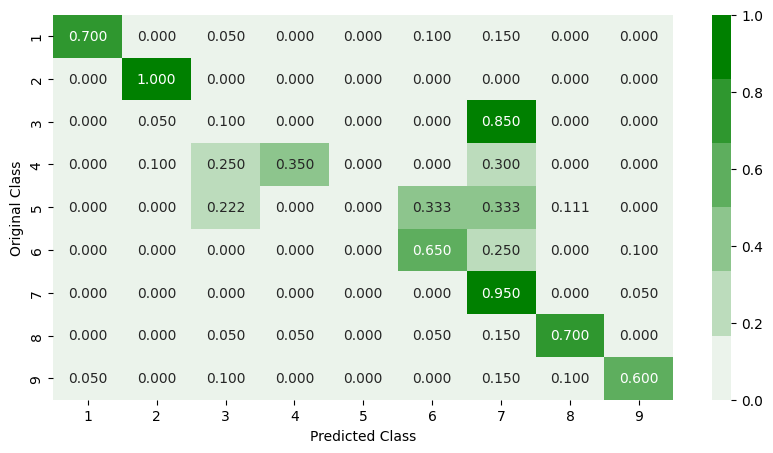

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [94]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.


alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

22- Random Forest Classifier ONLY on .asm file features

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for c =  10 is 0.2732300108419397
log_loss for c =  50 is 0.25205979761674635
log_loss for c =  100 is 0.24516375680004873
log_loss for c =  500 is 0.24546247497603554
log_loss for c =  1000 is 0.24677139096549552
log_loss for c =  2000 is 0.24720646272595148
log_loss for c =  3000 is 0.24755628708684183


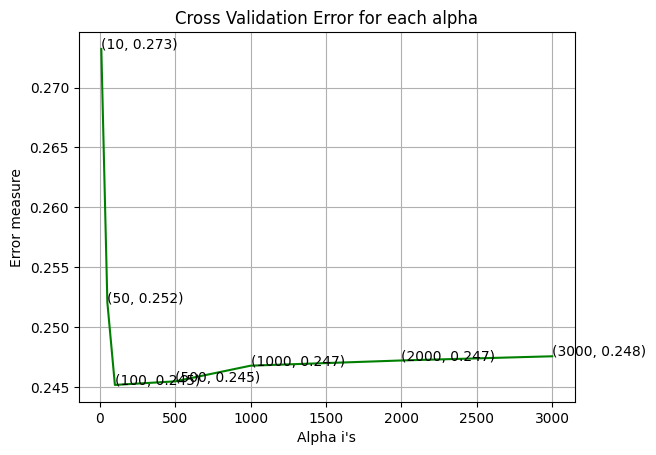

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


log loss for train data 0.1277121067681309


C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


log loss for cv data 0.24516375680004873


C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(


log loss for test data 0.24010768462246096
Number of misclassified points  3.5502958579881656
-------------------------------------------------- Confusion matrix --------------------------------------------------


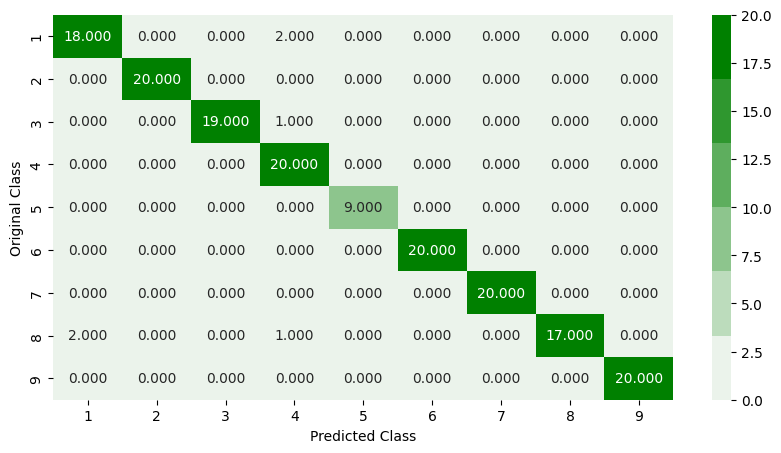

-------------------------------------------------- Precision matrix --------------------------------------------------


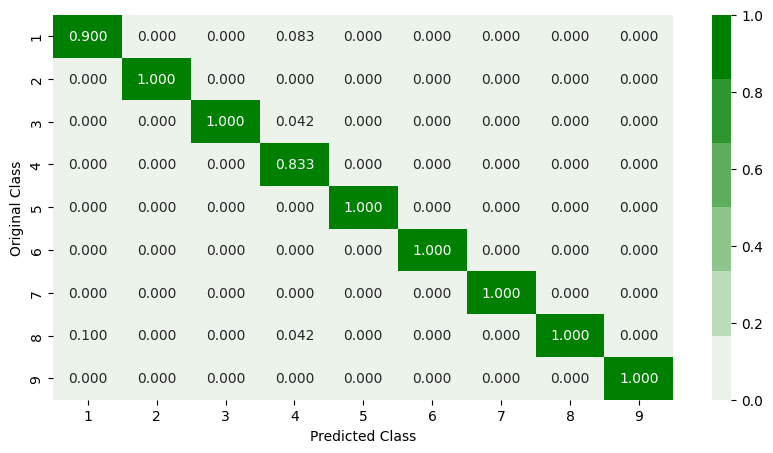

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


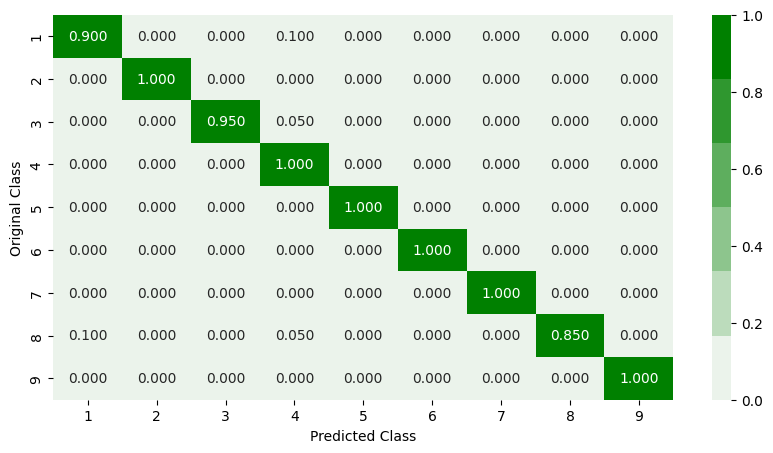

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [95]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

23-  XgBoost Classifier ONLY on .asm file features

C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
C:\Users\youse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:2910: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always

log_loss for c =  10 is 0.3015302084923843
log_loss for c =  50 is 0.29035859933109415
log_loss for c =  100 is 0.2885629781890168
log_loss for c =  500 is 0.2879750794922986
log_loss for c =  1000 is 0.2879764689097366
log_loss for c =  2000 is 0.2879703242441041
log_loss for c =  3000 is 0.28797100387099966


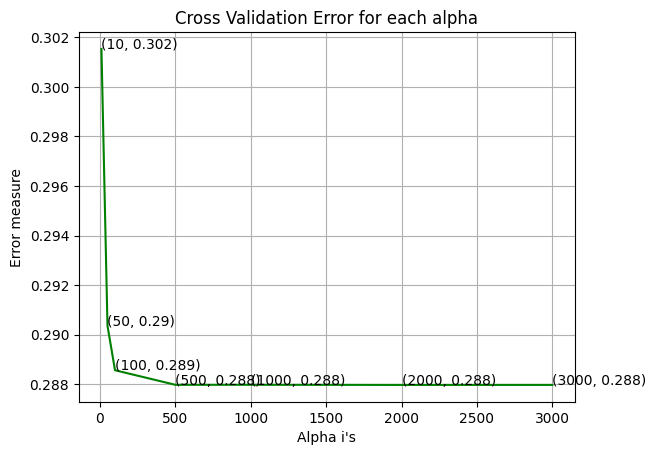

For values of best alpha =  2000 The train log loss is: 0.13383881346328308
For values of best alpha =  2000 The cross validation log loss is: 0.2879703242441041
For values of best alpha =  2000 The test log loss is: 0.2505146353127897
Number of misclassified points  2.366863905325444
-------------------------------------------------- Confusion matrix --------------------------------------------------


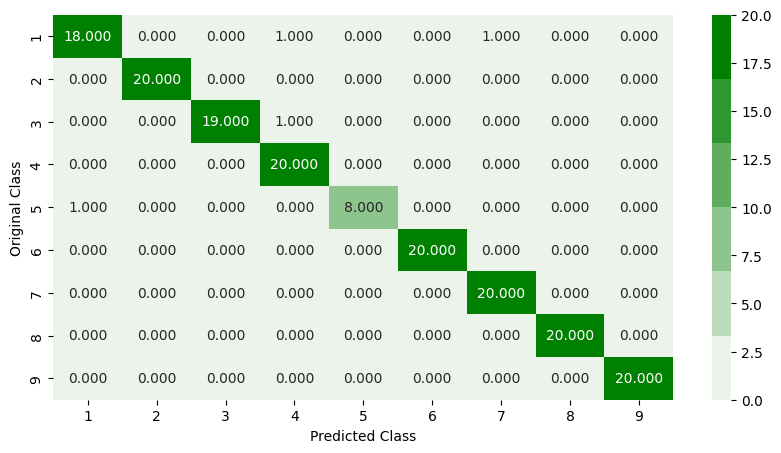

-------------------------------------------------- Precision matrix --------------------------------------------------


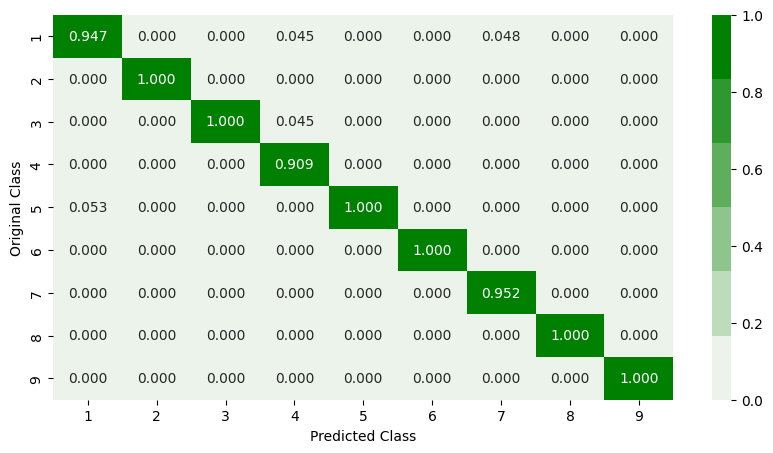

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


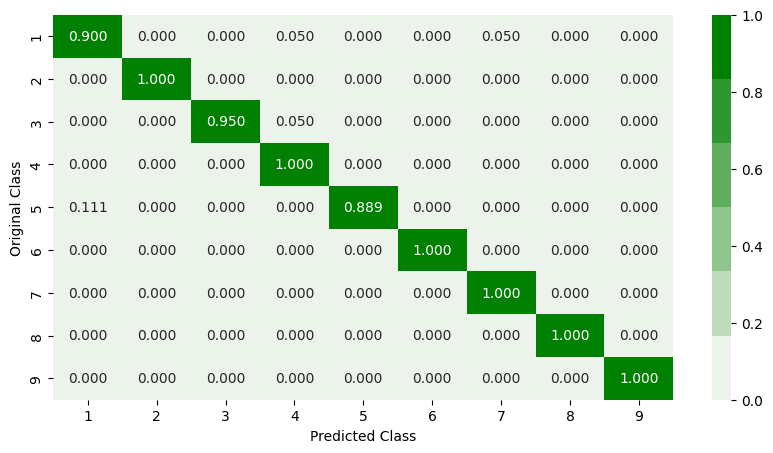

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [96]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    x_cfl=XGBClassifier(n_estimators=i,nthread=-1)
    x_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=x_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

x_cfl=XGBClassifier(n_estimators=alpha[best_alpha],nthread=-1)
x_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
    
predict_y = sig_clf.predict_proba(X_train_asm)

print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

24- Xgboost Classifier with best hyperparameters ( ONLY on .asm file features ) 

In [97]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_asm,y_train_asm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.1, 0.3, 0.5, 1],
                                        'learning_rate': [0.01, 0.03, 0.05, 0.1,
                                                          0.15, 0.2],
                                        'max_depth': [3, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000,
                                                         2000],
                                        'subsample': [0.1, 0.3, 0.5, 1]},
                   verbose=10)

25- File sizes of Byte files - Feature Extraction -For FINAL Model Train 


In [106]:
%%time

# This cell's code is what we have already ran earlier in the experimentation part
# Including here again for the sake of completeness
Y=pd.read_csv( "trainLabels.csv")

files=os.listdir( 'trainBytes')

filenames=Y['Id'].tolist()

class_y=Y['Class'].tolist()

class_bytes=[]

sizebytes=[]

fnames=[]

for file in tqdm(files):
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('trainBytes/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)

byte_feature_size=pd.DataFrame({'ID':fnames, 'size':sizebytes,'Class':class_bytes})

print (byte_feature_size.head())

  0%|          | 0/842 [00:00<?, ?it/s]

100%|██████████| 842/842 [00:00<00:00, 908.16it/s] 

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  4.234863      9
1  01IsoiSMh5gxyDYTl4CB  5.538818      2
2  01jsnpXSAlgw6aPeDxrU  3.887939      9
3  01kcPWA9K2BOxQeS5Rju  0.574219      1
4  01SuzwMJEIXsK7A8dQbl  0.370850      8
CPU times: total: 266 ms
Wall time: 948 ms


In [107]:
print (random_cfl.best_params_)

{'subsample': 0.3, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.1}


In [108]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance

x_cfl=XGBClassifier(n_estimators=200,subsample=0.5,learning_rate=0.15,colsample_bytree=0.5,max_depth=3)
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)

predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))

train loss 0.12379230168105061
cv loss 0.2413817955543562
test loss 0.21324075936174972


<h1 style="font-size:250%; font-family:cursive; color:#ff6666;"><b> 40. File Size of ASM Files - Feature Extraction - Final Model Training <a id="40"></a> </b></h1>


#### [Back to the top](#0)

This cell's code is what we have already ran earlier in the experimentation part, including below here again for the sake of completeness


In [110]:
# file sizes of byte files
# This code is very much similar to what has been used to extract sizes of 
# byte files earlier.
files=os.listdir( 'trainBytes')

filenames=Y['ID'].tolist()

class_y=Y['Class'].tolist()

class_bytes=[]

sizebytes=[]

fnames=[]

for file in tqdm(files):
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat( 'trainBytes/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)

asm_file_size=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})

# asm_file_size.to_csv(root_path + "featurization/asm_file_size.csv", index=False)

asm_file_size.head()

KeyError: 'ID'